In [ ]:
# install the dependencies
!pip install gamspy folium googlemaps numpy pandas matplotlib

In [1]:
import numpy as np
import pandas as pd
import math
import gamspy.math as gpm
from gamspy import (
    Container,Set,Alias,Parameter,Variable,Equation,Model,Problem,Sense,Options,
    Domain,Number,Sum,Product,Smax,Smin,Ord,Card,SpecialValues,
)
import sys
import matplotlib.pyplot as plt

# One Day in Disneyland Magic Kingdom
### By: Yiheng Su

## 1. Introduction

Disneyland Magic Kingdom (Orlando, FL) offers a great number of rides and attractions, but long wait times and the occasional ride closure make it challenging to fully enjoy the park in just one day. Simply wandering around the park and choosing rides as you go is unlikely to yield the best possible experience—especially if it’s crowded or if you have particular attractions in mind that matter more to you than others. Deciding where to go first, how to allocate your limited time, and how to adapt to wait times are all instereting problems.

In this project, I plan to tackle these issues by formulating and solving several optimization models that create "happy" one-day schedule. The goals include:

1. **Maximizing the number of attractions visited** within the available operating hours.
2. **Minimizing the leaving time**—including both queueing and walking—so that the day is used efficiently.
3. **Minimizing the travelling time**, which is the time spend going from one ride to another.
4. **Maximizing personal ratings for rides**-including maximizing the sum of these ratings for an experience aligned with personal preferences.

This work builds on concepts of the Traveling Salesman Problem (TSP). The complexity of this project is significantly higher than the examples covered in lectures, due to:

- **Larger Datasets:** More places to play, much longer time slots, and more parameters to consider.
- **Additional Constraints:** Preferences, wait times, travel time, and occasional ride closures.

By integrating these elements, this project will produce a practical Disneyland itinerary that considers both the static factors, such as travel distances and ride durations, and the dynamic aspects, such as wait times and ride availability.

## 2. Data

### 2.1 Ride Names and Locations on the Map
I have included a total of 31 attractions and rides at Disneyland, along with 1 entrance and 1 exit. Since the ride names are often long and challenging to use in coding, I assigned each a shorter alias for convenience. Additionally, I recorded the latitude and longitude coordinates for each attraction using Google Maps. For consistency, the aliases will be used throughout the project to refer to the full ride names. This data is stored in `Data/ride_coordinates.csv`.

In [2]:
ride_coordinates_df = pd.read_csv('Data/ride_coordinates.csv', float_precision='high')
ride_names = ride_coordinates_df['Alias'].tolist()
ride_coordinates_dict = ride_coordinates_df.set_index('Alias')[['Latitude', 'Longitude']].apply(tuple, axis=1).to_dict()
ride_coordinates_df

,Ride Name,Alias,Latitude,Longitude
0,Astro Orbiter,Orbiter,28.418569,-81.579124
1,The Barnstormer,Barnstormer,28.420881,-81.578319
2,Big Thunder Mountain Railroad,Big Thunder Mtn.,28.420464,-81.584484
3,Buzz Lightyear's Space Ranger Spin,Buzz SRS,28.418333,-81.579579
4,Dumbo the Flying Elephant,Dumbo,28.420544,-81.578673
5,Enchanted Tales with Belle,Enchanted Tales,28.421057,-81.580943
6,Haunted Mansion,Mansion,28.420657,-81.582993
7,"""it's a small world""",Small World,28.420705,-81.581927
8,Jungle Cruise,Jungle Cruise,28.418232,-81.583381
9,Mad Tea Party,Mad Tea Party,28.420067,-81.579620


Now that we have the coordinates, we can use the Google Maps API to display them on a map. Each marker is interactive, and clicking on one will show the name of that location.

In [ ]:
import folium
import googlemaps

# 🚨 IMPORTANT: Insert your own Google Maps API key below
API_KEY = "YOUR_GOOGLE_MAPS_API_KEY"  # <-- Replace this with your actual API key
gmaps = googlemaps.Client(key=API_KEY)

# m = folium.Map(location=ride_coordinates_dict["Entrance"], zoom_start=17)

# Create the map centered near the first place in the list
start_coords = ride_coordinates_dict[ride_names[-2]]
map = folium.Map(location=start_coords, zoom_start=17)

# Add markers with labels and nodes for each ride in the sorted list
for i, place in enumerate(ride_names, start=1):
    # Add a CircleMarker as the small node
    folium.CircleMarker(
        location=ride_coordinates_dict[place],
        radius=2,  # Small circle size
        color="red",
        fill=True,
        fill_color="red",
        fill_opacity=0.7
    ).add_to(map)
    
map

### 2.2 Ride Wait Times and Availability

I collected real-time wait time data from a [third-party website](https://wdwpassport.com/wait-times/magic-kingdom) that aggregates official disneyland app information. This data was sampled every five minutes throughout a full operating day. When a ride becomes temporarily unavailable or closes for maintenance, it is indicated in the wait time data as “N/A.” 
I crawled data for a day and the raw data is stored in `wait_times_2024_10_29.csv` and the cleaned data is stored in `cleaned_wait_times_2024_10_29.csv`.

I performed the following steps for data cleaning and processing:

1. The ride names are usually long and difficult to write when coding, so I assigned each name a shorter alias.

2. The first row of the dataset stores the actual timestamps when the data was crawled. I converted these timestamps into indices 0, 5, 10, …, 980, representing minutes elapsed since the park opened. This indexing simplifies the modeling process. However, when visualizing the data, we will need to convert these indices back to the corresponding real-time values for better interpretability.

2. For wait times marked as "N/A," which indicates that the ride is unavailable during certain time slots, I replaced "N/A" with a large integer (10,000 minutes). This value is much greater than Disneyland's total operating hours, ensuring the model avoids selecting rides with such high wait times if it is designed correctly.  

3. Since the wait time data is collected at five-minute intervals, I discretized it down to one-minute intervals using linear interpolation. A nice feature of the data is that the wait times are always multiples of 5 in the Disneyland app (e.g., 5, 10, 25, 30 minutes). This property allows me to guarantee that the interpolated wait times at each minute remain integers. Here’s why:

At consective times $t_1$ and $t_2$, the slope and intercept for linear interpolation are calculated as follows:
$$
\text{slope} = \frac{\text{wait}(t_2) - \text{wait}(t_1)}{t_2 - t_1} = \frac{\text{wait}(t_2) - \text{wait}(t_1)}{5}
$$
$$
\text{intercept} = \text{wait}(t_1),
$$

where $\text{wait}(t)$ represents the wait time at time $t$. Since each $\text{wait}(t)$ is a multiple of 5, the difference $\text{wait}(t_2) - \text{wait}(t_1)$ is also a multiple of 5. Dividing this difference by 5 ensures that the slope is an integer. The intercept, which is directly equal to $\text{wait}(t_1)$, is also an integer.

Because both the slope and intercept are integers, the interpolated values for each minute between $t_1$ and $t_2$ are guaranteed to be integers. This allows the use of integer programming while preserving the accuracy of the interpolated data.

4. In cases where a ride is unavailable at time $t_1$ and becomes available at time $t_2$, I set the wait time at $t_1$ to 0 and applied linear interpolation between $t_1$ and $t_2$.

The data is cleaned and processed in the `disneyland_data_clean.ipynb` file in the Data folder. The Data Crawling part is in `disneyland_data.py`.

In [4]:
wait_time_df = pd.read_csv('data/cleaned_wait_times_2024_10_29.csv', index_col=0)
wait_time_df.head()

,0,1,2,3,4,5,6,7,8,9,...,971,972,973,974,975,976,977,978,979,980
Orbiter,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,3.0,4.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
Barnstormer,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
Big Thunder Mtn.,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,...,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
Buzz SRS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
Dumbo,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0


We can interpret the data as follows: for example, at the park’s opening time (time 0), there is no wait time for  Orbiter and Buzz SRS. However, we need to wait 5 minutes for Barnstormer and Dumbo. Meanwhile, Big Thunder Mountain is closed.

### 2.3 Distance Between Rides
I maunally typed all the distance between any two rides from disneyland official app. The data is stored in `Data/distance.csv`.

In [5]:
distance_df = pd.read_csv('Data/distance.csv', index_col=0)
distance_df.head()

,Orbiter,Barnstormer,Big Thunder Mtn.,Buzz SRS,Dumbo,Enchanted Tales,Mansion,Small World,Jungle Cruise,Mad Tea Party,...,Seven Dwarfs Mine Train,Space Mtn.,Tiana Bayou Adv.,TL Speedway,TL Mover,TRON,Under the Sea,Fireworks,Entrance,Exit
Orbiter,0,6,10,1,5,7,7,7,7,3,...,4,2,10,2,1,3,6,4,6,6
Barnstormer,6,0,12,6,2,6,6,6,10,3,...,4,5,11,4,6,4,3,6,9,9
Big Thunder Mtn.,10,12,0,10,11,10,6,7,5,9,...,9,12,2,10,10,13,11,7,10,10
Buzz SRS,1,6,10,0,5,7,7,6,7,4,...,5,3,9,2,1,4,6,4,6,6
Dumbo,5,2,11,5,0,5,7,5,9,2,...,3,5,10,3,5,5,2,5,8,8


Notice that this data is symmetric. For example, the walking distance from Orbiter to Barnstormer is 6 minutes, which is the same as the distance from Barnstormer to Orbiter.

### 2.4 Duration for Rides
I maunally cope all the duration for ride from this [webiste](https://touringplans.com/disneyland/attractions/duration). The data is stored in `Data/distance.csv`.

In [6]:
# Read only the first and second columns, setting the first column as the index
duration_df = pd.read_csv('Data/disney_ride_durations_in_minutes.csv', usecols=[0, 1], index_col=0)

# Apply the ceiling function to all values in the DataFrame
duration_df = duration_df.apply(np.ceil)

# Display the DataFrame
duration_df

,Ride Duration
Orbiter,15.0
Barnstormer,2.0
Big Thunder Mtn.,4.0
Buzz SRS,5.0
Dumbo,2.0
Enchanted Tales,20.0
Mansion,8.0
Small World,11.0
Jungle Cruise,10.0
Mad Tea Party,2.0


The entrance and exit have a duration of 0 minutes. All durations are represented as integers.

## 3. Optimization Model
I plan to tackle these issues by formulating and solving several optimization models that create "happy" one-day schedule. The goals include:

1. **Maximizing the number of attractions visited** within the available operating hours.
2. **Minimizing the leaving time**—including both queueing and walking—so that the day is used efficiently.
3. **Maximizing personal ratings for rides**-including maximizing the sum of these ratings for an experience aligned with personal preferences.


### 3.1 Maximizing the Number of Attractions Visited
In this section, we introduce the integer programming model designed to maximize the number of rides visited within the park’s operating hours. We assume that each attraction can be visited at most once and that the sequence in which attractions are visited respects both travel and waiting times. Our objective is to choose a subset and order of attractions to maximize the total number of rides experienced before the park closes.

The model is defined as follows:

- **Sets**:
  - $ \text{ride} $: The set of rides available in the park.
  - $ i $: The discrete time points available (e.g., minutes from park opening).

- **Parameters**:
  - $ \text{distance}(r_1, r_2)  \in \mathbb{Z} $: The travel time between rides $ r_1 $ and $ r_2 $.
  - $ \text{wait\_time}(r, t) \in \mathbb{Z}$: The waiting time for ride $ r $ at time $ t $.
  - $ \text{duration}(r) \in \mathbb{Z}$: The duration of ride $ r $.
  - $ \text{close\_time} $: The time when the park closes. The close time is 980 minutes.
  - $ t(i) \in \mathbb{Z}$: The specific time corresponding to index $ i $. $t(i) \in [0, 980]$. The open time is 7:30am (corresponding to 0) and the close time is 11:50pm (corresponding to 980).

- **Decision Variables**:
  - $ \text{visited}(r) \in \{0,1\} $: Indicates whether ride $ r $ is visited.
  - $ x(r, i) \in \{0,1\} $: Binary variable indicating whether ride $ r $ is arrived at time $ t(i) $.
  - $ \text{order}(r_1, r_2) \in \{0,1\} $: Binary variable indicating if ride $ r_1 $ is visited before ride $ r_2 $.
  - $ \text{arrival\_time}(r) \in \mathbb{Z} $: The arrival time at ride $ r $.

- **Objective Function**:
  $$
  \max \sum_{r \in \text{ride}} \text{visited}(r)
  $$

  The objective is to maximize the total number of rides visited.

- **Constraints**:
  1. **Select Exactly One Start Time if Visited**: each chosen ride must be arrived at a specific time during the day, and a ride cannot be visited multiple times or at multiple times. If a ride is not played, then we make sure the start time of it is 0.
     $$
     \sum_{i} x(r,i) = \text{visited}(r) \quad \forall r
     $$
  
  2. **Arrival Time Definition**: the arrival time at each ride based on the $x(r, i)$. If $x(r, i)$ is 1, then the arrival time of ride $r$ is time $i$.
     $$
     \text{arrival\_time}(r) = \sum_{i} t(i) x(r,i) \quad \forall r
     $$
  
  3. **End Time Constraints**: we need to arrive at every ride at least before the close time
     $$
     \text{arrival\_time}(r) \leq \text{close\_time}  \quad \forall r
     $$

  4. **Predecessor/Successor Constraints for Start/End Rides**:
     - Entrance ride has no predecessor and only one successor.
      $$
         \sum_{r_2 \in \text{ride}} \text{order}(r_2, \text{Entrance}) = 0
      $$
      $$
         \sum_{r_2 \in \text{ride}} \text{order}(\text{Entrance}, r_2) = 1
      $$
     - Exit ride has one predecessor and no successors.
      $$
         \sum_{r_2 \in \text{ride}} \text{order}(r_2, \text{Exit}) = 1
      $$
      $$
         \sum_{r_2 \in \text{ride}} \text{order}(\text{Exit}, r_2) = 0
      $$
     - All other visited rides, if they are visited, they have exactly one predecessor and one successor. If they are not visited, they have no predecessor or successor.
      $$
         \sum_{r_1 \in \text{ride}} \text{order}(r_1, r) = \text{visited}(r) \quad \forall r \notin \{\text{Entrance}, \text{Exit}\}
      $$
      $$
         \sum_{r_2 \in \text{ride}} \text{order}(r, r_2) = \text{visited}(r) \quad \forall r \notin \{\text{Entrance}, \text{Exit}\}
      $$

  5. **Sequence Timing**:
     if $ \text{order}(r_1, r_2) = 1 $, meaning $r_1$ is visited before $r_2$, the arrival time of $r_2$ must logically be greater than the arrival time of $r_1$, plus the waiting time for $r_1$ at its arrival, the duration of $r_1$, and the travel time from $r_1$ to $r_2$. If $\text{order}(r_1, r_2) = 0$, meaning no sequence constraint between two rides, we use a big M to turn off this constraint.
     $$
     \text{arrival\_time}(r_2) \geq \text{arrival\_time}(r_1) + \text{duration}(r_1) + \sum_{i} \text{wait\_time}(r_1,i) x(r_1,i) + \text{distance}(r_1, r_2) - M(1 - \text{order}(r_1, r_2))
     $$

  6. **No Forcing of Unvisited Rides**: if $r_1$ is not visited, we do not want $r_1$ to be predecessor or successor of any other rides.
     $$
     \text{order}(r_1, r_2) \leq \text{visited}(r_1), \quad \text{order}(r_1, r_2) \leq \text{visited}(r_2) \quad \forall r_1, r_2
     $$
   
   7. **Fireworks Show Constraint**: the firework show begins at 9:30pm. I do not want to miss it, so I need to arrive at the firework show place at 9:30pm.
      $$
      x(\text{Fireworks}, 840) = 1
      $$



In [7]:
options = Options(relative_optimality_gap=1e-7, absolute_optimality_gap=0, variable_listing_limit=0, equation_listing_limit=200)

m = Container(options=options)

In [8]:
# One set for all rides and one set for all times
ride = m.addSet('ride', records=ride_names)
ride2 = m.addAlias('ride2', ride)
i = m.addSet('i', records=wait_time_df.columns.tolist())

close_time_data = int(wait_time_df.columns[-1])
bigM = close_time_data * 2 # Big M for later on timing constraints

# Parameters
distance = m.addParameter('distance', domain=[ride, ride], records=distance_df.to_numpy())
wait_time = m.addParameter('wait_time', domain=[ride, i], records=wait_time_df.to_numpy().astype(int))
duration_data = m.addParameter('duration', domain=[ride], records=duration_df.to_numpy())
close_time = m.addParameter('close_time', records=close_time_data)
t = m.addParameter('t', domain=[i], records=np.array(wait_time_df.columns.tolist(), dtype=int))

# Variables
visited = m.addVariable('visited', 'binary', domain=[ride], description="indicates if a ride is visited")
x = m.addVariable('x', 'binary', domain=[ride, i], description="indicator variable for ride i at time t")
order = m.addVariable('order', 'binary', domain=[ride, ride2], description="indicator variable for ride i before ride j")
arrival_time = m.addVariable('arrival_time', 'integer', domain=[ride], description="arrival time at ride i")
arrival_time.lo[ride] = 0
arrival_time.up[ride] = close_time

Let's define some visualization code here. Later on, we can directly use them

In [130]:
def plot_schedules(sorted_rides1, sorted_rides2=None, schedule1_name='Schedule 1', schedule2_name='Schedule 2', rate=None):
    def plot_single_schedule(sorted_rides, x_offset):
        times = []
        arrival_labels = []
        line_segments = []
        current_time = 0

        # Generate timeline data based on the rides sequence
        for i in range(len(sorted_rides)):
            next_ride_name = None
            ride_name = sorted_rides.iloc[i]['ride']
            distance_data = 0  # Initialize distance_data to 0
            if i + 1 < len(sorted_rides):
                next_ride_name = sorted_rides.iloc[i + 1]['ride']
                distance_data = distance_df.loc[ride_name, next_ride_name]

            arrival_time_data = int(sorted_rides.iloc[i]['level'])
            wait_time = int(wait_time_df.loc[ride_name, str(arrival_time_data)])
            duration_data = int(duration_df.loc[ride_name, 'Ride Duration'])

            # If current time is less than the scheduled arrival time, add empty space (nothing-to-do time)
            if current_time < arrival_time_data:
                line_segments.append((current_time, arrival_time_data, 'gray', ''))
                current_time = arrival_time_data  # Update current time to the arrival time

            # Prepare arrival label
            arrival_time_str = f"{(arrival_time_data+30) // 60 + 7}:{(arrival_time_data+30) % 60:02d}"

            if isinstance(rate, pd.DataFrame):
                # Check if the ride exists in the rate DataFrame
                if ride_name in rate['ride'].values:
                    ride_rate = int(rate.loc[rate['ride'] == ride_name, 'value'].iloc[0])
                    # print(ride_rate)
                    arrival_labels.append(f"{ride_name} ({arrival_time_str}) (rate: {ride_rate})")
                else:
                    # If ride not found in rate DataFrame, show without rate
                    arrival_labels.append(f"{ride_name} ({arrival_time_str})")
            else:
                # If rate is not provided as a DataFrame
                arrival_labels.append(f"{ride_name} ({arrival_time_str})")

            # Add arrival event with a circle marker and label
            times.append(current_time)

            # Add wait time segment if there is a wait time
            if wait_time > 0:
                start_time = current_time
                current_time += wait_time
                line_segments.append((start_time, current_time, 'red', f"{wait_time}"))

            # Add play duration segment
            start_time = current_time
            current_time += duration_data
            line_segments.append((start_time, current_time, 'green', f"{duration_data}"))

            # Add travel time segment if there's a next ride
            if next_ride_name is not None and distance_data > 0:
                start_time = current_time
                current_time += distance_data
                line_segments.append((start_time, current_time, 'blue', f"{distance_data}"))

        # Plot the segments and labels
        for start_time, end_time, color, text in line_segments:
            plt.plot([x_offset, x_offset], [start_time, end_time], color=color, linewidth=2)
            mid_point = (start_time + end_time) / 2
            # Only display text if it’s meaningful
            if text not in ['0', '1', '2']:
                plt.text(x_offset + 0.012, mid_point, text, ha='left', va='center', fontsize=9, color=color)

        for i, time in enumerate(times):
            plt.plot(x_offset, time, 'o', color="black", markersize=3)
            plt.text(x_offset - 0.012, time, arrival_labels[i], ha='right', va='center', fontsize=10, color="black")
        
        return current_time

    plt.figure(figsize=(12, 50))

    # Plot the first schedule
    max_time1 = plot_single_schedule(sorted_rides1, x_offset=1)

    # Plot the second schedule if provided
    if sorted_rides2 is not None:
        max_time2 = plot_single_schedule(sorted_rides2, x_offset=2)
        plt.xlim(0.5, 2.5)
        plt.xticks([1, 2], [schedule1_name, schedule2_name])
        max_time = max(max_time1, max_time2)
    else:
        plt.xlim(0.5, 1.5)
        plt.xticks([1], [schedule1_name])
        max_time = max_time1

    plt.ylim(0 - 10, max_time + 20)
    plt.ylabel("Time (minutes)", fontsize=14)
    plt.title("Ride Journey Timeline Comparison", fontsize=16)

    plt.legend(handles=[
        plt.Line2D([0], [0], color='red', linewidth=2, label='Wait Time'),
        plt.Line2D([0], [0], color='green', linewidth=2, label='Play Time'),
        plt.Line2D([0], [0], color='blue', linewidth=2, label='Travel Time'),
        plt.Line2D([0], [0], color='gray', linewidth=2, label='Nothing to do'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=8, label='Arrival Time')
    ], loc="lower right", fontsize=12)

    plt.show()


def plot_routine_map(sorted_rides, locations, api_key):
    # Initialize the Google Maps client
    gmaps = googlemaps.Client(key=api_key)

    start_coords = locations['Entrance']
    m = folium.Map(location=start_coords, zoom_start=17)

    sorted_rides_names = sorted_rides['ride'].tolist()
    for i, place in enumerate(sorted_rides_names, start=1):
        # Add a CircleMarker as the small node
        folium.CircleMarker(
            location=locations[place],
            radius=6,  # Small circle size
            color="red",
            fill=True,
            fill_color="red",
            fill_opacity=0.7
        ).add_to(m)

        folium.Marker(
            location=locations[place],
            popup=f"{i}. {place}",
            icon=folium.DivIcon(html=f"""<div style="font-size: 12px; font-weight: bold; color: white;">{i}</div>""")
        ).add_to(m)

    for i in range(len(sorted_rides_names) - 1):
        origin = locations[sorted_rides_names[i]]
        destination = locations[sorted_rides_names[i + 1]]

        directions_result = gmaps.directions(
            origin=origin,
            destination=destination,
            mode="walking"
        )

        route = directions_result[0]['legs'][0]['steps']
        route_coords = [
            (step['start_location']['lat'], step['start_location']['lng']) for step in route
        ]
        route_coords.append((route[-1]['end_location']['lat'], route[-1]['end_location']['lng']))

        # Add the route as a PolyLine to the map
        folium.PolyLine(
            route_coords,
            color="blue",
            weight=2,
            opacity=0.5,
            popup=f"Path from {i + 1}: {sorted_rides_names[i]} to {i + 2}: {sorted_rides_names[i + 1]}"
        ).add_to(m)

    return m


def plot_routine(sorted_rides, locations):
    from folium.plugins import PolyLineTextPath

    start_coords = locations['Entrance']
    m = folium.Map(location=start_coords, zoom_start=17)

    ride_names = sorted_rides['ride'].tolist()

    for i, place in enumerate(ride_names, start=1):
        folium.CircleMarker(
            location=locations[place],
            radius=6,
            color="red",
            fill=True,
            fill_color="red",
            fill_opacity=0.7
        ).add_to(m)
        
        folium.Marker(
            location=locations[place],
            popup=f"{i}. {place}",
            icon=folium.DivIcon(html=f"""<div style="font-size: 12px; font-weight: bold; color: white;">{i}</div>""")
        ).add_to(m)

    for i in range(len(ride_names) - 1):
        origin = locations[ride_names[i]]
        destination = locations[ride_names[i + 1]]
        
        line = folium.PolyLine(
            locations=[origin, destination],
            color="blue",
            weight=2,
            opacity=0.5,
            popup=f"Path from {i + 1}: {ride_names[i]} to {i + 2}: {ride_names[i + 1]}"
        ).add_to(m)

        PolyLineTextPath(
            line,
            '>                  ',
            repeat=True,
            offset=2,
            opacity=0.5,
            attributes={'fill': 'blue', 'font-weight': 'bold', 'font-size': '10'}
        ).add_to(m)

    return m

In [ ]:
# entrance, exit, and fireworks must be visited
visited.fx['Entrance'] = 1
visited.fx['Exit'] = 1
visited.fx['Fireworks'] = 1
# The fireworks show only happens at 9:30 pm
x.fx['Fireworks', '840'] = 1

In [132]:
# If visited, choose exactly one start time; if not visited, no time slot chosen
select_one_time = m.addEquation('select_one_time', domain=[ride])
select_one_time[ride] = Sum(i, x[ride, i]) == visited[ride]

# define arrival time as the chosen arrival time if visited
arrival_time_eq = m.addEquation('arrival_time_eq', domain=[ride])
arrival_time_eq[ride] = arrival_time[ride] == Sum(i, t[i]*x[ride, i])

# no ride should exceed the park close time (if visited)
close_time_eq = m.addEquation('close_time_eq', domain=[ride])
# time_feasibility[ride] = arrival_time[ride] + duration_data[ride] <= close_time + (1 - visited[ride])*close_time
close_time_eq[ride] = arrival_time[ride] <= close_time

# min_arrival_time_if_visited = m.addEquation('min_arrival_time_if_visited', domain=[ride])
# min_arrival_time_if_visited[ride] = arrival_time[ride] >= visited[ride]

In [133]:
# TSP Constraints:
# entrance should have no predecessor and 1 successor if visited
entrance_first_pre = m.addEquation('entrance_first_pre')
entrance_first_pre[:] = Sum(ride2, order[ride2, 'Entrance']) == 0
entrance_first_succ = m.addEquation('entrance_first_succ')
entrance_first_succ[:] = Sum(ride2, order['Entrance', ride2]) == 1

# exit should have 1 predecessor and no successor if visited
exit_last_pre = m.addEquation('exit_last_pre')
exit_last_pre[:] = Sum(ride2, order[ride2, 'Exit']) == 1
exit_last_succ = m.addEquation('exit_last_succ')
exit_last_succ[:] = Sum(ride2, order['Exit', ride2]) == 0

# for all other rides, if visited, exactly one predecessor and one successor
first_and_last = m.addSet('first_and_last', domain=ride, records=['Entrance', 'Exit'])
one_predecessor = m.addEquation('one_predecessor', domain=[ride])
one_predecessor[ride].where[~first_and_last[ride]] = (
    Sum(ride2, order[ride2, ride]) == visited[ride]
)

one_successor = m.addEquation('one_successor', domain=[ride])
one_successor[ride].where[~first_and_last[ride]] = (
    Sum(ride2, order[ride, ride2]) == visited[ride]
)

In [134]:
# if order[ride, ride2] = 1, then ride2 must start after ride finishes + travel time + wait time
before_eq = m.addEquation('before_eq', domain=[ride, ride2])
before_eq[ride, ride2] = arrival_time[ride2] >= arrival_time[ride] + duration_data[ride] \
                         + Sum(i, wait_time[ride, i]*x[ride, i]) + distance[ride, ride2] \
                         - bigM*(1 - order[ride, ride2])

# if a ride is not visited, no order constraints should force timing:
no_unvisited_forcing1 = m.addEquation('no_unvisited_forcing1', domain=[ride, ride2])
no_unvisited_forcing1[ride, ride2] = order[ride, ride2] <= visited[ride]

no_unvisited_forcing2 = m.addEquation('no_unvisited_forcing2', domain=[ride, ride2])
no_unvisited_forcing2[ride, ride2] = order[ride, ride2] <= visited[ride2]

In [67]:
# Objective: Maximize the number of visited rides
obj = Sum(ride, visited[ride])
disney_maxRides = m.addModel('disney_revised', equations=m.getEquations(), problem=Problem.MIP, sense=Sense.MAX, objective=obj)
disney_maxRides.solve('gurobi', output=None, options=Options(log_file="log_max.txt", time_limit=600))

,Solver Status,Model Status,Objective,Num of Equations,Num of Variables,Model Type,Solver,Solver Time
0,Normal,OptimalGlobal,33,3433,33529,MIP,GUROBI,13.464


The optimal solution shows that we can enjoy all the rides before disneyland closes! Let’s take a look at the play schedule generated by GAMSpy.

In [68]:
sorted_rides = arrival_time.records.sort_values(by='level')
sorted_rides

,ride,level,marginal,lower,upper,scale
31,Entrance,0.0,-0.0,0.0,980.0,1.0
26,TL Speedway,10.0,-0.0,0.0,980.0,1.0
18,Philharmonic,36.0,-0.0,0.0,980.0,1.0
6,Mansion,67.0,-0.0,0.0,980.0,1.0
21,Pirates,98.0,-0.0,0.0,980.0,1.0
27,TL Mover,120.0,-0.0,0.0,980.0,1.0
15,Dashing Show,143.0,-0.0,0.0,980.0,1.0
3,Buzz SRS,152.0,-0.0,0.0,980.0,1.0
0,Orbiter,177.0,-0.0,0.0,980.0,1.0
10,Magic Carpets,208.0,-0.0,0.0,980.0,1.0


It seems that we need to enter Disneyland precisely at 7:30 AM and leave by 11:50 PM. To visit all the rides, we’ll need to spend the entire day there. Next, let’s visualize the schedule, including wait times, ride durations, and travel times. The schedule might also include some downtime, which we will also display using Matplotlib.

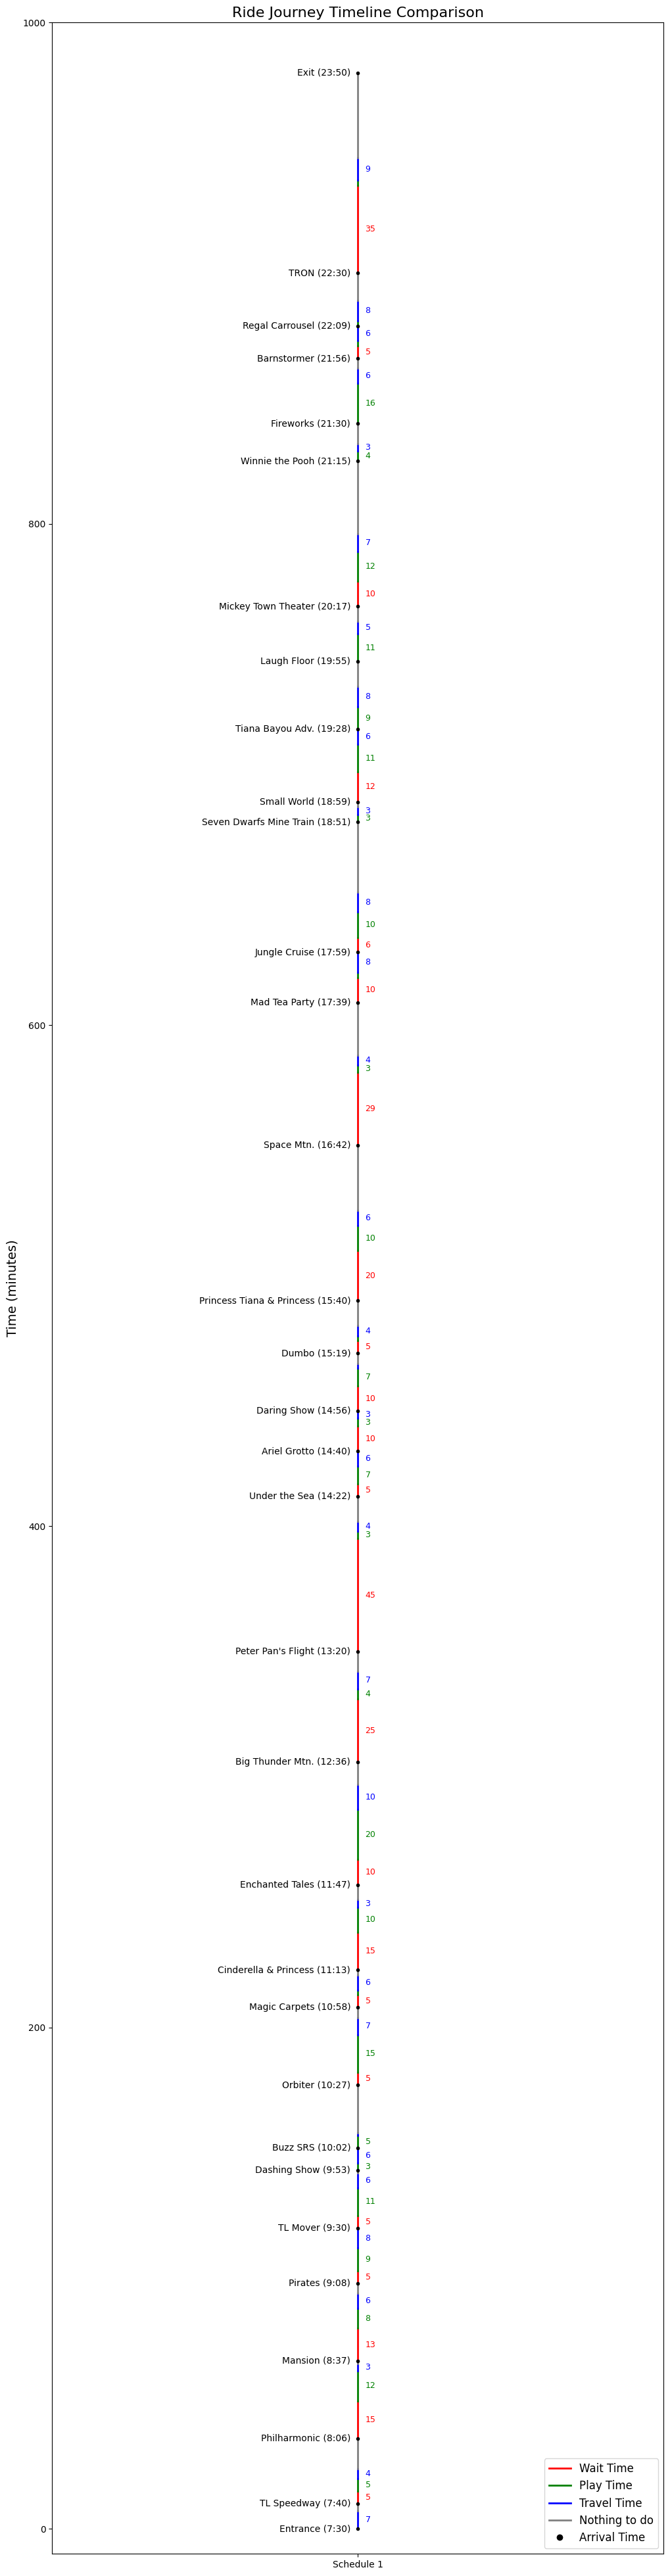

In [69]:
plot_schedules(sorted_rides)

The schedule looks reasonable as we start at the entrance and end at the exit. We also watch the fireworks show at 9:30 PM. We can also visualize the routines on google map using folium and googlemaps API.

In [70]:
plot_routine_map(sorted_rides, ride_coordinates_dict, API_KEY)

The map route is not accurate, but it confirms that we visit every ride. The numbers in the cirlce tell us what the playing order. The darker blue lines indicate paths that we walk multiple times. However, it is difficult to see the order of visits from this map. We need to follow the number of red points to see the order, but it is hard to tell which path we choose. To address this, I designed another route that simply connects the rides using direct edges to indicate the order. This does not reflect the actual routine, but it can provide more information.

In [71]:
plot_routine(sorted_rides, ride_coordinates_dict)

Starting at the entrance (circle 1), we can follow the directed edges to visit all the rides, and finally, we arrive at the exit (circle 33).
### 3.2 Minimizing the Leaving Time
Now that we know we have enough time to enjoy all the rides at Disneyland, the next question is: what is the minimal departure time? Currently, we plan to leave just before the park closes, but is it possible to leave earlier? What is the earliest time we can leave? Leaving earlier would give us more time to rest and prepare for tomorrow’s trip.
We need to add two more constraints and change the objective function from 3.1.

1. **Play All Rides**:
   to ensure that all 33 rides are visited, we enforce the constraint:
   $$
   \sum_{r \in \text{ride}} \text{visited}(r) = 33
   $$

2. **Minimize Departure Time**:
   We introduce a variable $t_{\text{end}}$ to represent the time of departure from Disneyland. The departure time must be no earlier than the latest arrival time across all visited rides:
   $$
   t_{\text{end}} \geq \text{arrival\_time}(r) \quad \forall r
   $$

3. **Objective**:
   The goal is to minimize $t_{\text{end}}$, ensuring the earliest possible departure time:
   $$
   \min t_{\text{end}}
   $$

In [72]:
# play all the rides
play_all_eq = m.addEquation('play_all_eq')
play_all_eq[:] =  Sum(ride, visited[ride]) == 33

# minimize the total time
t_end = m.addVariable('t_end', 'free')
t_end_eq = m.addEquation('t_end_eq', domain=[ride])
t_end_eq[ride] = t_end >= arrival_time[ride]

disney_minTime = m.addModel('disney_minTime', equations=m.getEquations(), problem=Problem.MIP, sense=Sense.MIN, objective=t_end)
disney_minTime.solve('gurobi', output=sys.stdout, options=Options(log_file="log_min.txt", time_limit=600), solver_options={"mipstart":1})

--- _1330d936-503f-4bb4-aacd-a745221a17e2.gms(320) 71 Mb
--- Job _1330d936-503f-4bb4-aacd-a745221a17e2.gms Start 12/13/24 03:52:19 48.2.0 4a7dd217 DAX-DAC arm 64bit/macOS
--- Applying:
    /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/gamspy_base/gmsprmun.txt
--- GAMS Parameters defined
    MIP gurobi
    Input /var/folders/6z/bpsd8cv959n930gw9gd94q780000gn/T/tmpyy9a1_y7/_1330d936-503f-4bb4-aacd-a745221a17e2.gms
    Output /var/folders/6z/bpsd8cv959n930gw9gd94q780000gn/T/tmpyy9a1_y7/_1330d936-503f-4bb4-aacd-a745221a17e2.lst
    ScrDir /var/folders/6z/bpsd8cv959n930gw9gd94q780000gn/T/tmpyy9a1_y7/tmp2dv7enl1/
    SysDir /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/gamspy_base/
    LogOption 4
    LogFile /Users/yihengsu/Desktop/CS524Optimization/Project/log_min.txt
    Trace /var/folders/6z/bpsd8cv959n930gw9gd94q780000gn/T/tmpyy9a1_y7/_1330d936-503f-4bb4-aacd-a745221a17e2.txt
    License /Library/Frameworks/Python.frame

,Solver Status,Model Status,Objective,Num of Equations,Num of Variables,Model Type,Solver,Solver Time
0,Normal,OptimalGlobal,861,3467,33530,MIP,GUROBI,66.611


We have achieved a global optimum of 861 minutes, allowing us to leave Disneyland at 9:51 PM—an improvement of one hour! Let's see more visualizations of the new schedule and try to understand how we improved. Notice that here I use the `solver_options={"mipstart":1}`. It is because I already obtained a feasible solution in 3.1. Here, I am using the this feasible solution as my initial guess for the model. If I am not using `{"mipstart":1}`, the model struggles to find even one feasible solution initially!

In [73]:
sorted_rides_min = arrival_time.records.sort_values(by='level')
sorted_rides_min

,ride,level,marginal,lower,upper,scale
31,Entrance,0.0,-0.0,0.0,980.0,1.0
26,TL Speedway,10.0,-0.0,0.0,980.0,1.0
28,TRON,25.0,-0.0,0.0,980.0,1.0
18,Philharmonic,34.0,-0.0,0.0,980.0,1.0
6,Mansion,66.0,-0.0,0.0,980.0,1.0
21,Pirates,93.0,-0.0,0.0,980.0,1.0
27,TL Mover,116.0,-0.0,0.0,980.0,1.0
9,Mad Tea Party,141.0,-0.0,0.0,980.0,1.0
3,Buzz SRS,152.0,-0.0,0.0,980.0,1.0
11,Winnie the Pooh,162.0,-0.0,0.0,980.0,1.0


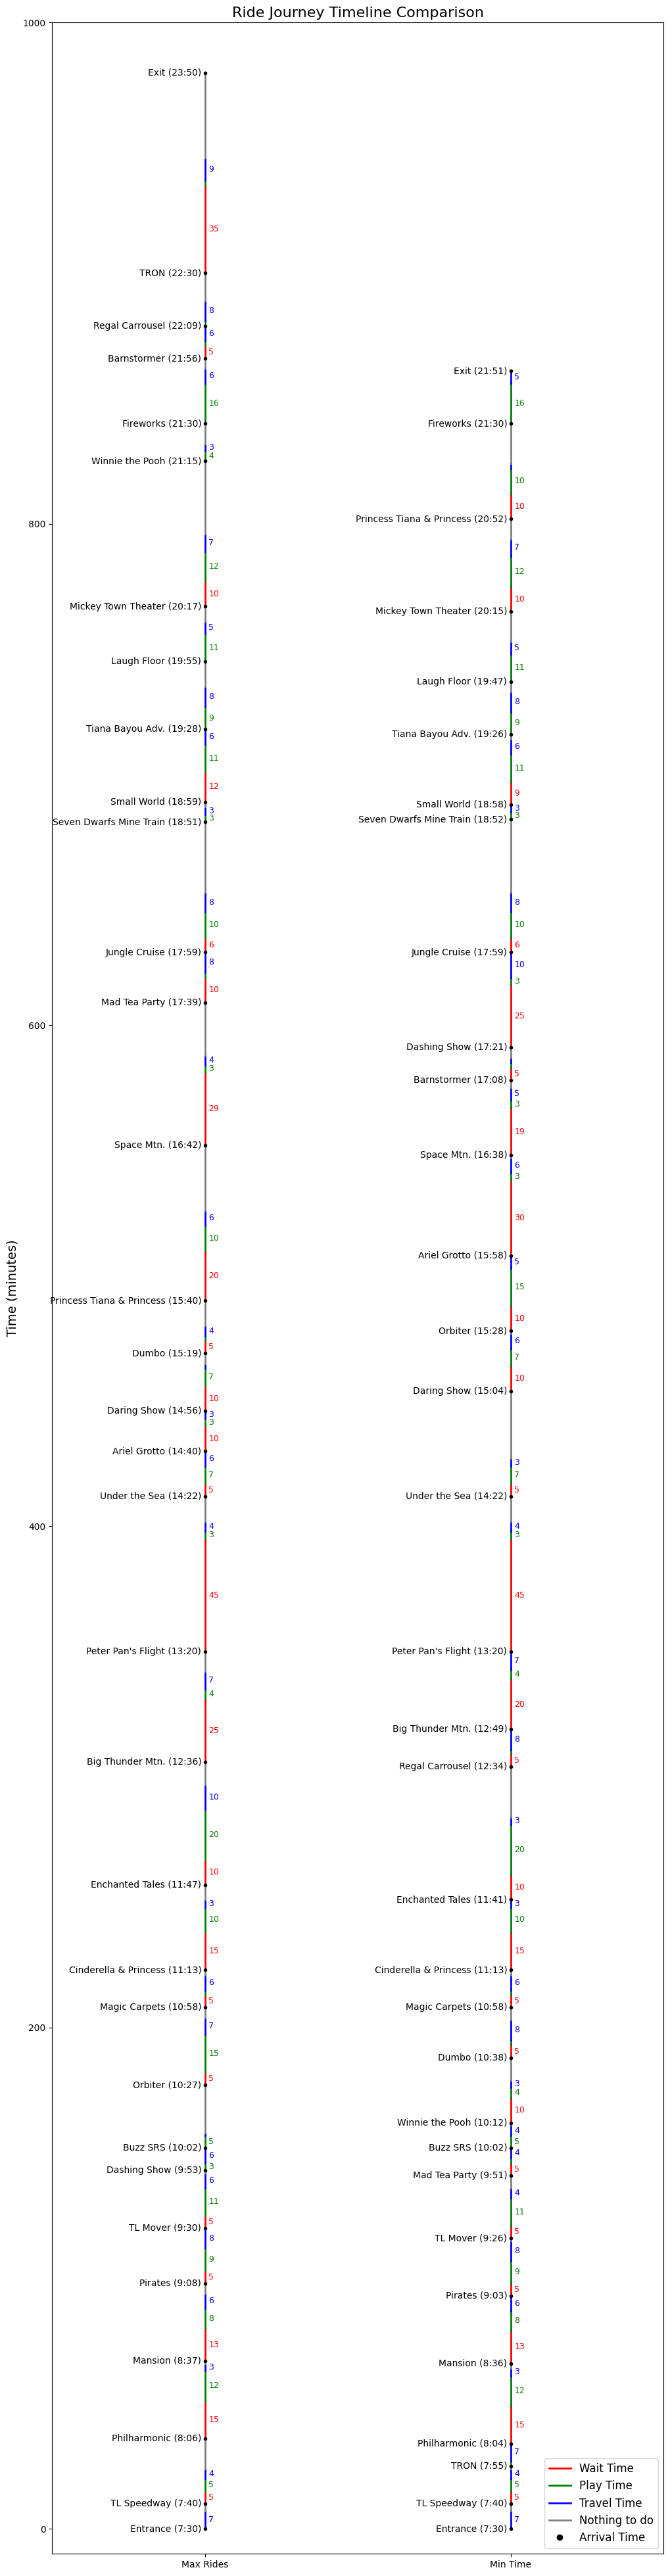

In [74]:
plot_schedules(sorted_rides, sorted_rides_min, 'Max Rides', 'Min Time')

Looking at the new schedule (on the right side above), we can see that before 21:30PM we have played and visited all the rides. The only two places left is firworks show and exit. Therefore, we will watch the fireworks and then go home! Thus, the leaving time should be $$21:30 + \text{duration(firework)} + \text{distance(firework, exit)} = 21:30 + 16\text{min} + 5\text{min} = 21:51,$$
which is exactly the optimal solution for 3.2. 

Moreover, since I am using `{'mipstart':1}`, we can see that the order of two schedules are quite similar with few swich in the order.

The following figure will show our new schedule on the map.

In [75]:
plot_routine(sorted_rides_min, ride_coordinates_dict)

### 3.2.1 “Maximize” the Start Time.
7:30 AM—ugh, too early for me. If I follow the schedule in 3.2, I would be really tired the whole day. Can I enter Disneyland later and still play all the rides while leaving as early as possible? In this section, let’s maximize the start time. Here are the new constraint we need:

1. **Fix Leaving Time**:
   The Leaving time is fixed at the optimal value found earlier:
   $$
   x(\text{Exit}, 861) = 1
   $$

2. **Maximize Start Time**:
   A new variable, $ \text{start\_time} $, is introduced to represent the earliest arrival time across all visited rides. The start time must be less than or equal to the arrival time of any ride:
   $$
   \text{start\_time} \leq \text{arrival\_time}(r) \quad \forall r
   $$

3. **Objective**:
   The goal is to maximize $ \text{start\_time} $:
   $$
   \max \text{start\_time}
   $$

In [76]:
x.fx['Exit', str(int(disney_minTime.objective_value))] = 1
arrival_time.up[ride] = disney_minTime.objective_value

start_time = m.addVariable('start_time', 'free')
start_time_eq = m.addEquation('start_time_eq', domain=[ride])
start_time_eq[ride] = start_time <= arrival_time[ride]

disney_maxStart = m.addModel('disney_maxStart', equations=m.getEquations(), problem=Problem.MIP, sense=Sense.MAX, objective=start_time)
disney_maxStart.solve('gurobi', output=sys.stdout, options=Options(log_file="log_maxStart.txt", time_limit=1200), solver_options={"mipstart":1})

--- Job _1330d936-503f-4bb4-aacd-a745221a17e2.gms Start 12/13/24 03:53:27 48.2.0 4a7dd217 DAX-DAC arm 64bit/macOS
--- Applying:
    /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/gamspy_base/gmsprmun.txt
--- GAMS Parameters defined
    MIP gurobi
    Input /var/folders/6z/bpsd8cv959n930gw9gd94q780000gn/T/tmpyy9a1_y7/_1330d936-503f-4bb4-aacd-a745221a17e2.gms
    Output /var/folders/6z/bpsd8cv959n930gw9gd94q780000gn/T/tmpyy9a1_y7/_1330d936-503f-4bb4-aacd-a745221a17e2.lst
    ScrDir /var/folders/6z/bpsd8cv959n930gw9gd94q780000gn/T/tmpyy9a1_y7/tmp2dv7enl1/
    SysDir /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/gamspy_base/
    LogOption 4
    LogFile /Users/yihengsu/Desktop/CS524Optimization/Project/log_maxStart.txt
    Trace /var/folders/6z/bpsd8cv959n930gw9gd94q780000gn/T/tmpyy9a1_y7/_1330d936-503f-4bb4-aacd-a745221a17e2.txt
    License /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/gams

[MODEL - WARNING] The solve was interrupted! Solve status: ResourceInterrupt. For further information, see https://gamspy.readthedocs.io/en/latest/reference/gamspy._model.html#gamspy.SolveStatus.


,Solver Status,Model Status,Objective,Num of Equations,Num of Variables,Model Type,Solver,Solver Time
0,Resource,Integer,91,3500,33531,MIP,GUROBI,1200.291


The solver provides an objective value of 121 minutes after running for 40 minutes, which means I can enter Disneyland around 9:00 AM. Although the solver log indicates that I am far from the optimal solution, I am quite satisfied with this result. Normally, I wake up before 9:00 AM since I have an optimization course at 9:50 AM three times a week :). I’m perfectly fine with arriving at disneyland around 9:00 AM. Let's see what our new schedule looks like comparing to the previous one in 3.2.

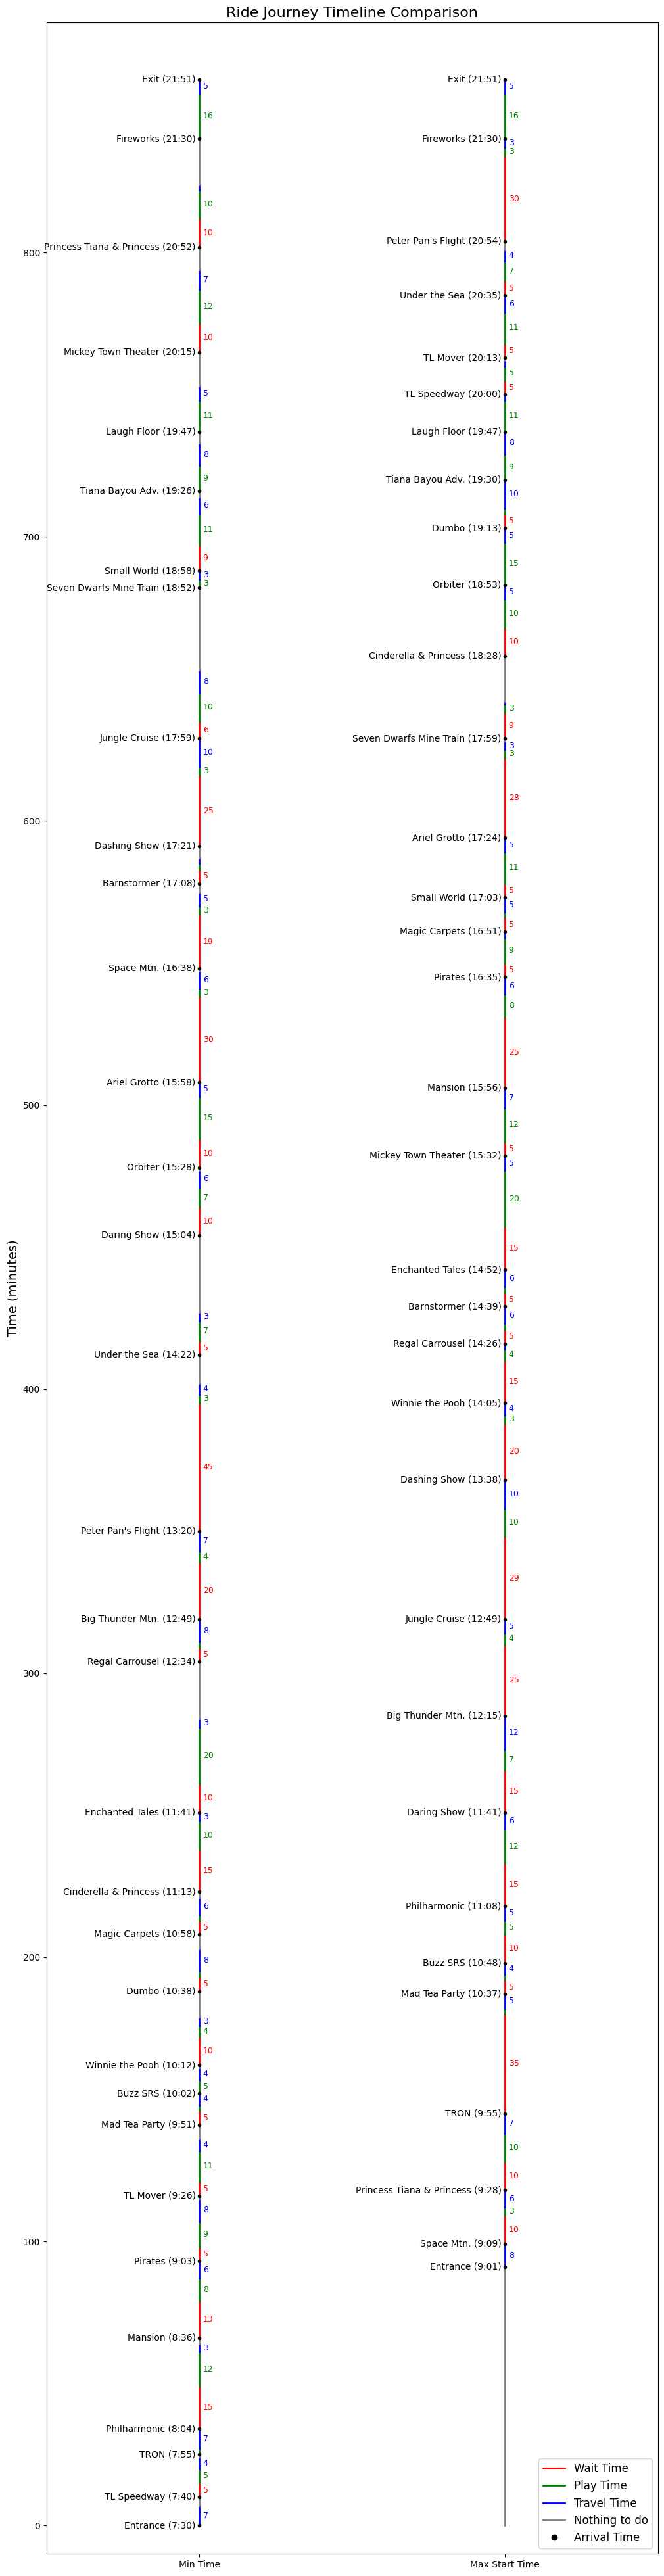

In [77]:
sorted_rides_maxStart = arrival_time.records.sort_values(by='level')
plot_schedules(sorted_rides_min, sorted_rides_maxStart, 'Min Time', 'Max Start Time')

Although I am still using `solver_options={"mipstart":1}`, the new schedule has a completely different order compared to the previous schedule generated in 3.2. We enter disneyland at 9:01 AM. The new schedule significantly reduces the “Nothing to do” time compared to the old schedule, as shown by the gray lines.

In [78]:
plot_routine(sorted_rides_maxStart, ride_coordinates_dict)

### 3.3 Minimize Travel Time
Looking at all previoius routines on the map, I think they are really messy. I need to walk back and forth many times. Now, I want to spend the least amount of time traveling around. Still, I do not want to enter disneyland at 7:30AM, as that is too early for me, but I can choose to enter the park a little earlier than 9:00AM. I chose the earliest time to be 8:20 AM because I experimented with the earliest opening time, and if we relax the earliest constraint slightly, it becomes much easier to find the optimal solution for minimizing travel time.
1. **Start Time Constraint:**
    The earliest time we enter the disneyland at is 8:20AM (50 minutes after disneyland opens).
    $$
    \text{arrival\_time}(r) \geq 50 \quad \forall r.
    $$
2. **Travel Time Minimization Objective:**
    We want to minimize the total travel time between consecutive rides. Travel time can be calculated as the sum of distances between each pair of rides $r$ and $r_2$, multiplied by $\text{order}(r, r_2)$, a binary variable indicating if ride $r$ is played immediately before $r_2.$
    $$
    \text{travel\_time} = \sum_{r} \sum_{r_2} \text{distance}(r, r_2) \cdot \text{order}(r, r_2).
    $$
    The objective is
    $$
    \min \quad \text{travel\_time}.
    $$

In [79]:
arrival_time.lo[ride] = 50
travel_time = Sum(ride, Sum(ride2, distance[ride, ride2]*order[ride, ride2]))

disney_minTravel = m.addModel('disney_minTravel', equations=m.getEquations(), problem=Problem.MIP, sense=Sense.MIN, objective=travel_time)
disney_minTravel.solve('gurobi', output=sys.stdout, options=Options(log_file="log_minTravel.txt", time_limit=600), solver_options={"mipstart":1})

--- _1330d936-503f-4bb4-aacd-a745221a17e2.gms(519) 74 Mb
--- Job _1330d936-503f-4bb4-aacd-a745221a17e2.gms Start 12/13/24 04:13:28 48.2.0 4a7dd217 DAX-DAC arm 64bit/macOS
--- Applying:
    /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/gamspy_base/gmsprmun.txt
--- GAMS Parameters defined
    MIP gurobi
    Input /var/folders/6z/bpsd8cv959n930gw9gd94q780000gn/T/tmpyy9a1_y7/_1330d936-503f-4bb4-aacd-a745221a17e2.gms
    Output /var/folders/6z/bpsd8cv959n930gw9gd94q780000gn/T/tmpyy9a1_y7/_1330d936-503f-4bb4-aacd-a745221a17e2.lst
    ScrDir /var/folders/6z/bpsd8cv959n930gw9gd94q780000gn/T/tmpyy9a1_y7/tmp2dv7enl1/
    SysDir /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/gamspy_base/
    LogOption 4
    LogFile /Users/yihengsu/Desktop/CS524Optimization/Project/log_minTravel.txt
    Trace /var/folders/6z/bpsd8cv959n930gw9gd94q780000gn/T/tmpyy9a1_y7/_1330d936-503f-4bb4-aacd-a745221a17e2.txt
    License /Library/Frameworks/Python

,Solver Status,Model Status,Objective,Num of Equations,Num of Variables,Model Type,Solver,Solver Time
0,Normal,OptimalGlobal,66,3501,33532,MIP,GUROBI,290.383


Here, we reach a global optimal 66, which means at least we need to spend 66 minutes on traveling. Well, that's definitely acceptable for me.

In [80]:
sorted_rides_minTravel = arrival_time.records.sort_values(by='level')
sorted_rides_minTravel

,ride,level,marginal,lower,upper,scale
31,Entrance,50.0,-0.0,50.0,861.0,1.0
16,Mickey Town Theater,74.0,-0.0,50.0,861.0,1.0
5,Enchanted Tales,111.0,-0.0,50.0,861.0,1.0
29,Under the Sea,134.0,-0.0,50.0,861.0,1.0
1,Barnstormer,150.0,-0.0,50.0,861.0,1.0
15,Dashing Show,160.0,-0.0,50.0,861.0,1.0
14,Daring Show,182.0,-0.0,50.0,861.0,1.0
4,Dumbo,201.0,-0.0,50.0,861.0,1.0
26,TL Speedway,211.0,-0.0,50.0,861.0,1.0
19,Laugh Floor,225.0,-0.0,50.0,861.0,1.0


In [81]:
plot_routine(sorted_rides_minTravel, ride_coordinates_dict)

Plotting the routine of this schedule, we have a much clearer and neater routine this time. We can easily identify a single route that starts from entrance 1 (8:20AM), then visits 2, 3, …, and finally ends at exit 33 (21:51PM). It does not seem like we are walking back and forth.

### 3.4 Maximize Personal Ratings for Rides
Before, we worked on a scenario where we could actually visit and experience all the rides. My data was collected on October 29, 2024, near Halloween. On that day, Disneyland offered [Mickey’s Not-So-Scary Halloween Party Special Event Ticket](https://disneyworld.disney.go.com/events-tours/magic-kingdom/mickeys-not-so-scary-halloween-party/). With this ticket, visitors can enter the park as early as 19:00 and stay until closing time.

Now, let’s imagine I only purchased this special event ticket. I suspect that I might not have enough time to play all the rides. I have no idea how many I can actually play. However, I don’t feel the need to visit all of them. Since I am more interested in some rides than in others, I would prefer to spend time on those I like most. Therefore, I created a new rating dataset in which I rate each ride from 0 to 5—indicating my preference from least liked to most liked. The new data is stored in the file `Data/rate.csv`.

In [135]:
rate_df = pd.read_csv('Data/rate.csv', header=None, index_col=0)
rate_df.to_numpy().flatten()
rate = m.addParameter('rate', domain=[ride], records=rate_df.to_numpy())
rate.records

,ride,value
0,Orbiter,3.0
1,Barnstormer,5.0
2,Big Thunder Mtn.,5.0
3,Buzz SRS,2.0
4,Dumbo,2.0
5,Enchanted Tales,1.0
6,Mansion,5.0
7,Small World,3.0
8,Jungle Cruise,4.0
9,Mad Tea Party,2.0


1. **Start Time Constraint:** Now, we enter the disneyland at 19:00 (690 minutes after it opens).
2. **Weighted Objective:** I really want to play those high rated rides more. To achieve this, I assign exponentially increasing weights to higher-rated rides so that improving the number of high-rating rides will always have a greater impact on the objective value than any combination of lower-rated rides.
$$
\text{Objective} = \sum_{\text{ride}} \text{visited(ride)} * M^{\text{rate[ride]}}
$$

Now, the question is how to determine the value of $M$. For a ride with a rating of 5, we obtain a value of $M^5$. If $M^5$ outweighs the combined value of all rides with a rating lower than 5, then selecting more 5-rated rides will always be optimal. Similarly, this logic applies for rides rated 4 and below. Thus, we need:
$$
M^5 > \sum_{\text{rate(ride) <=4}} M^{\text{rate[ride]}},
$$
$$
M^4 > \sum_{\text{rate(ride) <= 3}} M^{\text{rate[ride]}},
$$
$$
M^3 > \sum_{\text{rate(ride) <=  2}} M^{\text{rate[ride]}},
$$
$$
M^2 > \sum_{\text{rate(ride) <=  1}} M^{\text{rate[ride]}}.
$$
I did not try we solve this system of inequalities to find $M$. We only need to find one valid $M$. Checking $M=10$ is simple and effective:
There are 11 rides with rating 5, 3 with rating 4, 5 with rating 3, 6 with rating 2, and 6 with rating 1. Clearly, all the inequalities above will hold.

In [136]:
# reset the decision variables
visited = m.addVariable('visited', 'binary', domain=[ride], description="indicates if a ride is visited")
x = m.addVariable('x', 'binary', domain=[ride, i], description="indicator variable for ride i at time t")
order = m.addVariable('order', 'binary', domain=[ride, ride2], description="indicator variable for ride i before ride j")
arrival_time = m.addVariable('arrival_time', 'integer', domain=[ride], description="arrival time at ride i")
arrival_time.lo[ride] = 0
arrival_time.up[ride] = close_time

In [137]:
special_event_start = 690
x.fx['Entrance', str(special_event_start)] = 1
M = 10

In [91]:
rate_obj = Sum(ride, visited[ride]*gpm.power(M, rate[ride]))
disney_maxRate = m.addModel('disney_maxRate', equations=[select_one_time, arrival_time_eq, close_time_eq, entrance_first_pre, entrance_first_succ, 
                                                         exit_last_pre, exit_last_succ, one_predecessor, one_successor, before_eq, no_unvisited_forcing1, 
                                                         no_unvisited_forcing2],                            
                            problem=Problem.MIP, sense=Sense.MAX, objective=rate_obj)
disney_maxRate.solve('gurobi', output=sys.stdout, options=Options(log_file="log_RateMax.txt", time_limit=1200))

--- _1330d936-503f-4bb4-aacd-a745221a17e2.gms(771) 74 Mb
--- Job _1330d936-503f-4bb4-aacd-a745221a17e2.gms Start 12/13/24 04:23:37 48.2.0 4a7dd217 DAX-DAC arm 64bit/macOS
--- Applying:
    /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/gamspy_base/gmsprmun.txt
--- GAMS Parameters defined
    MIP gurobi
    Input /var/folders/6z/bpsd8cv959n930gw9gd94q780000gn/T/tmpyy9a1_y7/_1330d936-503f-4bb4-aacd-a745221a17e2.gms
    Output /var/folders/6z/bpsd8cv959n930gw9gd94q780000gn/T/tmpyy9a1_y7/_1330d936-503f-4bb4-aacd-a745221a17e2.lst
    ScrDir /var/folders/6z/bpsd8cv959n930gw9gd94q780000gn/T/tmpyy9a1_y7/tmp2dv7enl1/
    SysDir /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/gamspy_base/
    LogOption 4
    LogFile /Users/yihengsu/Desktop/CS524Optimization/Project/log_RateMax.txt
    Trace /var/folders/6z/bpsd8cv959n930gw9gd94q780000gn/T/tmpyy9a1_y7/_1330d936-503f-4bb4-aacd-a745221a17e2.txt
    License /Library/Frameworks/Python.f

[MODEL - WARNING] The solve was interrupted! Solve status: ResourceInterrupt. For further information, see https://gamspy.readthedocs.io/en/latest/reference/gamspy._model.html#gamspy.SolveStatus.


,Solver Status,Model Status,Objective,Num of Equations,Num of Variables,Model Type,Solver,Solver Time
0,Resource,Integer,912402,3433,33529,MIP,GUROBI,1201.411


After running the solver for 20 minutes, we stopped with an objective value of 912,402. The solver log shows that the optimal bound is 1,135,662. It appears this bound is simply the weighted sum of all the rides:

$$
11 \times 10^5 + 3 \times 10^4 + 5 \times 10^3 + 6 \times 10^2 + 6 \times 10^1 + 2 \times 10^0 = 1{,}135{,}662.
$$

Since we do not have enough time to visit all the rides, reaching this optimal bound is impossible. Throughout the optimization, the bound did not decrease. One way to address this issue is to impose additional constraints on the number of rides we play. Doing so may help lower the bound and ultimately increase the achievable objective value.

In [92]:
sorted_rides_maxRate = arrival_time.records.sort_values(by='level')
sorted_rides_maxRate = sorted_rides_maxRate[sorted_rides_maxRate['level'] > 0]
sorted_rides_maxRate

,ride,level,marginal,lower,upper,scale
31,Entrance,690.0,-0.0,0.0,980.0,1.0
4,Dumbo,698.0,-0.0,0.0,980.0,1.0
25,Tiana Bayou Adv.,719.0,-0.0,0.0,980.0,1.0
30,Fireworks,734.0,-0.0,0.0,980.0,1.0
1,Barnstormer,756.0,-0.0,0.0,980.0,1.0
19,Laugh Floor,769.0,-0.0,0.0,980.0,1.0
2,Big Thunder Mtn.,790.0,-0.0,0.0,980.0,1.0
9,Mad Tea Party,813.0,-0.0,0.0,980.0,1.0
11,Winnie the Pooh,825.0,-0.0,0.0,980.0,1.0
26,TL Speedway,840.0,-0.0,0.0,980.0,1.0


Then, we can plot this schedule, including the detailed routine and its visualization on the map. This schedule allows us to play 9 out of the 11 5-rated rides, maximizing enjoyment while following an efficient route.

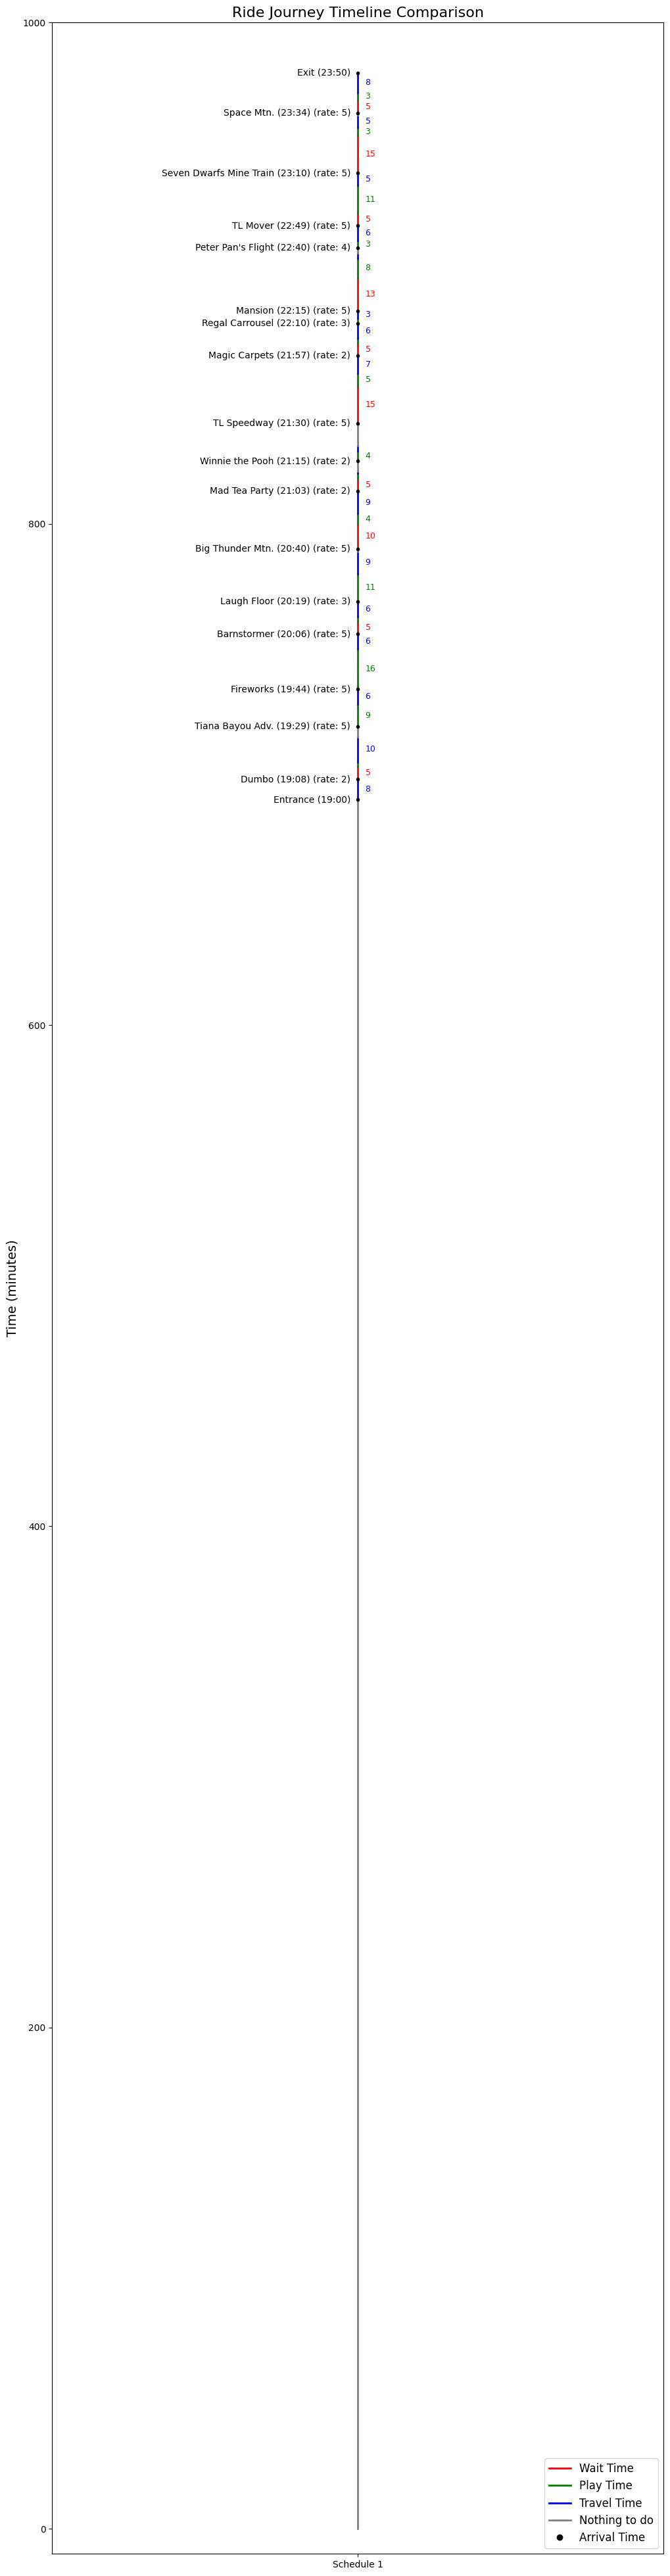

In [93]:
plot_schedules(sorted_rides_maxRate, rate=rate.records)

In [94]:
plot_routine(sorted_rides_maxRate, ride_coordinates_dict)

### 3.5 Conclusion
In conclusion, the most reasonable playing schedule is the one generated in section 3.3, which focuses on minimizing travel time. This schedule allows me to avoid arriving at Disneyland extremely early, such as 7:30 AM, and I can leave relatively early, around 10:00 PM. Moreover, with this schedule, I can experience all the rides Disneyland has to offer while minimizing travel time, meaning I won’t need to walk back and forth unnecessarily.

When focusing on maximizing the rating, the solver does not reach the optimal bound. However, I am satisfied with the resulting schedule, as it allows me to enjoy nearly all of the 5-rated rides (specifically, nine out of eleven). The following route on the map is the one generated in section 3.3, and it is my favorite schedule.

In [ ]:
plot_routine(sorted_rides_minTravel, ride_coordinates_dict)

### 3.6 Acknowledgement
I would like to express my sincere gratitude to Professor Michael Ferris for his guidance and support in helping me develop this model.

